In [38]:
import os
import numpy as np
from scipy import misc
import argparse
import json
import cv2

from tensorpack import *
from bone_point import Model
from reader import Data
from cfgs.config import cfg


from matplotlib import pyplot as plt
%matplotlib inline

In [39]:
img_name = "0d041d4e-7743-43bb-9547-4733ddac43e6.png"

In [40]:
# initialize the model
depth = 18
model = Model(depth)
sess_init = SaverRestore("train_log/bone_point/model-2500")
predict_config = PredictConfig(session_init=sess_init,
                               model=model,
                               input_names=["input"],
                               output_names=["logits"])

In [41]:
predict_func = OfflinePredictor(predict_config)

[0614 12:41:40 @regularize.py:18] Apply regularizer for conv0/W:0
[0614 12:41:40 @regularize.py:18] Apply regularizer for group0/block0/conv1/W:0
[0614 12:41:40 @regularize.py:18] Apply regularizer for group0/block0/conv2/W:0
[0614 12:41:40 @regularize.py:18] Apply regularizer for group0/block1/conv1/W:0
[0614 12:41:40 @regularize.py:18] Apply regularizer for group0/block1/conv2/W:0
[0614 12:41:40 @regularize.py:18] Apply regularizer for group1/block0/conv1/W:0
[0614 12:41:40 @regularize.py:18] Apply regularizer for group1/block0/conv2/W:0
[0614 12:41:40 @regularize.py:18] Apply regularizer for group1/block0/convshortcut/W:0
[0614 12:41:40 @regularize.py:18] Apply regularizer for group1/block1/conv1/W:0
[0614 12:41:40 @regularize.py:18] Apply regularizer for group1/block1/conv2/W:0
[0614 12:41:40 @regularize.py:18] Apply regularizer for group2/block0/conv1/W:0
[0614 12:41:40 @regularize.py:18] Apply regularizer for group2/block0/conv2/W:0
[0614 12:41:40 @regularize.py:18] Apply regular

In [42]:
img_path = "doodles/" + cfg.name + "/" + img_name
img = misc.imread(img_path)
input_img = np.expand_dims(img, axis=0)

In [43]:
predictions = predict_func([input_img])[0][0]
norm_bones = predictions + np.asarray(cfg.anchor_bones)

In [44]:
# restore bboxes from mask images
bboxes = []
for label_idx in range(cfg.obj_num):
    mask_path = img_path.replace("png", "mask." + str(label_idx) + ".png")
    cur_label_img = misc.imread(mask_path, mode='L')
    cur_label_img = np.minimum(cur_label_img, np.ones(cur_label_img.shape))

    t = np.nonzero(cur_label_img)
    ymin = np.min(t[0])
    ymax = np.max(t[0])
    xmin = np.min(t[1])
    xmax = np.max(t[1])
    bboxes.append([xmin, ymin, xmax, ymax])

In [45]:
print(norm_bones)

[ 0.36707342 -0.03898171  0.10840795 -0.12410708  0.13847763  0.37294325
 -0.1505029   0.14436481  1.79612286  0.08100012  2.10240424 -0.2180005
  2.52428351 -0.08822882 -2.10291771 -0.18574356 -2.45280852 -0.51409882
 -2.86757996 -0.09218242  0.53078452 -0.46391297  0.26353978 -0.08174003
 -0.06390384  0.30559013 -0.35312633  0.32630014  0.40359835 -0.4896836
  0.31446411 -0.10752618  0.08003589  0.29321218 -0.35818182  0.44531804
 -0.11745388 -0.54362162  0.16700215 -0.14793484  0.33683308  0.2491546
 -0.18098373  0.46433717  0.29977402 -0.68502056  0.28112331 -0.08205104
  0.16819097  0.34298043 -0.32743305  0.42648016]


In [46]:
# restore abolute coords for bones
bones = []
i = 0
for box_idx in cfg.match:
    norm_bone = norm_bones[i:i+2]
    i += 2
    [xmin, ymin, xmax, ymax] = bboxes[box_idx]
    xcenter = (xmax + xmin) / 2
    ycenter = (ymax + ymin) / 2
    box_width = (xmax - xmin)
    box_height = (ymax - ymin)
    x = norm_bone[0] * box_width + xcenter
    y = norm_bone[1] * box_height + ycenter
    bones.append([int(x), int(y)])

In [47]:
for bone in bones:
    img = cv2.circle(img, (bone[0], bone[1]), 2, (255, 255, 255), thickness=2, lineType=8, shift=0)

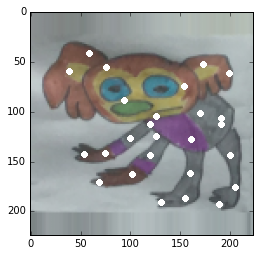

In [48]:
plt.imshow(img)